## Mounting Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
ROOT = r'/content/drive/Othercomputers/My Laptop/Deep Learning/Working Code'
os.chdir(ROOT)
assert os.getcwd() == ROOT

## Importing Libraries

In [ ]:
!pip install -q transformers

In [ ]:
!pip install -q tensorflow-addons

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import pandas as pd 
import nltk
import spacy
from wordcloud import WordCloud, STOPWORDS
from transformers import AutoTokenizer, AutoConfig, TFAutoModel
import tensorflow as tf
from tqdm.auto import tqdm
nlp = spacy.load("en_core_web_sm")
from typing import List, Tuple
import keras.backend as K
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import tensorflow_addons as tfa
import random
import warnings
import matplotlib

warnings.filterwarnings("ignore")

import os

## File paths

In [ ]:
TRAIN_PATH = "Dataset/train.csv"
TEST_PATH = "Dataset/test.csv"
FEATURES_PATH = "Dataset/features.csv"
PATIENT_NOTES_PATH = "Dataset/patient_notes.csv"
SAMPLE_SUBMISSION_PATH = "Dataset/sample_submission.csv"

## Assigning Model Parameters

In [ ]:
MODEL_NAME = 'microsoft/deberta-base'
DATA_PATH = f"../input/{MODEL_NAME}"
SEQUENCE_LENGTH = 512
TOKENIZER_PATH = f'{MODEL_NAME}_tokenizer'
BATCH_SIZE = 8
AUTOTUNE = tf.data.AUTOTUNE
EPOCHS = 20
MODEL_CHECKPOINT = f"model.h5"
LEARNING_RATE = 2e-5
#1000->2000
CLIP_NORM = 2000

## Setting Seed for training environment

In [ ]:
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
#42->0
SEED = 0
seed_everything(SEED)

## Loading and Displaying Features Dataset

In [ ]:
features_df = pd.read_csv(FEATURES_PATH)
print(f"Number of rows in features dataframe {len(features_df)}")
features_df.head()

Number of rows in features dataframe 143


,feature_num,case_num,feature_text
0,0,0,Family-history-of-MI-OR-Family-history-of-myoc...
1,1,0,Family-history-of-thyroid-disorder
2,2,0,Chest-pressure
3,3,0,Intermittent-symptoms
4,4,0,Lightheaded


## Loading and Displaying Patients Dataset

In [ ]:
patient_notes_df = pd.read_csv(PATIENT_NOTES_PATH)
print(f"Number of rows in patient notes dataframe {len(patient_notes_df)}")
patient_notes_df.head()

Number of rows in patient notes dataframe 42146


,pn_num,case_num,pn_history
0,0,0,"17-year-old male, has come to the student heal..."
1,1,0,17 yo male with recurrent palpitations for the...
2,2,0,Dillon Cleveland is a 17 y.o. male patient wit...
3,3,0,a 17 yo m c/o palpitation started 3 mos ago; \...
4,4,0,17yo male with no pmh here for evaluation of p...


## Loading and Displaying Train Dataset

In [ ]:
train_df = pd.read_csv(TRAIN_PATH)
print(f"Number of rows train dataframe {len(train_df)}")
train_df.head()

Number of rows train dataframe 14300


,id,case_num,pn_num,feature_num,annotation,location
0,00016_000,0,16,0,['dad with recent heart attcak'],['696 724']
1,00016_001,0,16,1,"['mom with ""thyroid disease']",['668 693']
2,00016_002,0,16,2,['chest pressure'],['203 217']
3,00016_003,0,16,3,"['intermittent episodes', 'episode']","['70 91', '176 183']"
4,00016_004,0,16,4,['felt as if he were going to pass out'],['222 258']


## Loading Auto Tokenizer from pretrained model

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.save_pretrained(f'{TOKENIZER_PATH}')

config = AutoConfig.from_pretrained(MODEL_NAME)
config.save_pretrained(f'{TOKENIZER_PATH}')

## Creating Model

In [ ]:
def create_model() -> tf.keras.Model:
    input_tokens = tf.keras.layers.Input(shape=(SEQUENCE_LENGTH,), dtype=tf.int32)
    attention_mask = tf.keras.layers.Input(shape=(SEQUENCE_LENGTH,), dtype=tf.int32)

    config = AutoConfig.from_pretrained(MODEL_NAME, output_hidden_states=True)
    backbone = TFAutoModel.from_pretrained(MODEL_NAME, config=config)

    out = backbone(input_tokens, attention_mask=attention_mask)[0]
    out = tf.keras.layers.Dropout(0.2)(out)
    out = tf.keras.layers.Dense(256, activation='sigmoid')(out)
    out = tf.keras.layers.Dense(1, activation='sigmoid')(out)

    return tf.keras.Model(inputs=[input_tokens, attention_mask], outputs=out)

In [ ]:
model = create_model()
model.summary()

All model checkpoint layers were used when initializing TFDebertaModel.

All the layers of TFDebertaModel were initialized from the model checkpoint at microsoft/deberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDebertaModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 tf_deberta_model (TFDebertaMod  TFBaseModelOutput(l  138601728  ['input_1[0][0]',                
 el)                            ast_hidden_state=(N               'input_2[0][0]']                
                                one, 512, 768),                                                   
                                 hidden_states=((No                                           

## Merging different datasets to create Train dataframe

In [ ]:
train = train_df.merge(features_df, on=['feature_num', 'case_num'], how='left')
train = train.merge(patient_notes_df, on=['pn_num', 'case_num'], how='left')
train['annotation_length'] = train['annotation'].apply(len)

train.head()

,id,case_num,pn_num,feature_num,annotation,location,feature_text,pn_history,annotation_length
0,00016_000,0,16,0,['dad with recent heart attcak'],['696 724'],Family-history-of-MI-OR-Family-history-of-myoc...,HPI: 17yo M presents with palpitations. Patien...,32
1,00016_001,0,16,1,"['mom with ""thyroid disease']",['668 693'],Family-history-of-thyroid-disorder,HPI: 17yo M presents with palpitations. Patien...,29
2,00016_002,0,16,2,['chest pressure'],['203 217'],Chest-pressure,HPI: 17yo M presents with palpitations. Patien...,18
3,00016_003,0,16,3,"['intermittent episodes', 'episode']","['70 91', '176 183']",Intermittent-symptoms,HPI: 17yo M presents with palpitations. Patien...,36
4,00016_004,0,16,4,['felt as if he were going to pass out'],['222 258'],Lightheaded,HPI: 17yo M presents with palpitations. Patien...,40


## Creating Input Tokens 

In [ ]:
def create_inputs(pn_history: str, feature_text: str) -> Tuple[np.array]:
    tokens = tokenizer(
        pn_history,
        feature_text,
        max_length=SEQUENCE_LENGTH,
        padding="max_length",
        add_special_tokens=True,
    )
    
    input_ids = tokens['input_ids']
    attention_mask = tokens["attention_mask"]
    return (np.array(input_ids), np.array(attention_mask))

## Decoding Annotation's start and end locations

In [ ]:
def decode_location(location: str) -> List[Tuple[int]]:
    location = location.replace("[", '')
    location = location.replace("]", '')
    location = location.replace("'", '')
    location = location.replace(",", '')
    location = location.replace(";", ' ')
    location = location.split(" ")
    if list(filter(None, location)) == []:
        return []
    
    location = list(map(int, location))
    location_tuple_list = []
    
    for i in range(0, len(location), 2):
        x1 = location[i]
        x2 = location[i+1]
        location_tuple_list.append((x1, x2))
    
    return location_tuple_list

## Creating Annotation's labels

In [ ]:
def create_labels(pn_history, annotation_length, location_list):
    tokenized = tokenizer(
        pn_history,
        add_special_tokens=True,
        max_length=SEQUENCE_LENGTH,
        padding="max_length",
        return_offsets_mapping=True
    )
    
    offset_mapping = tokenized["offset_mapping"]
    label = np.zeros(len(offset_mapping))
    if annotation_length != 0:
        locations = decode_location(location_list)
        for location in locations:
            start_idx, end_idx = -1, -1
            start, end = location
            for idx in range(len(offset_mapping)):
                if (start_idx == -1) & (start < offset_mapping[idx][0]):
                    start_idx = idx - 1
                if (end_idx == -1) & (end <= offset_mapping[idx][1]):
                    end_idx = idx + 1
            if start_idx == -1:
                start_idx = end_idx
            if (start_idx != -1) & (end_idx != -1):
                label[start_idx:end_idx] = 1
            
    return np.array(label)

## Splitting Dataset into Train and Test

In [ ]:
train, valid = train_test_split(
    train[['pn_history', 'feature_text','annotation_length', 'location']],
    test_size=0.2
)

## Getting the Dataset into X and y format

In [ ]:
def get_dataset_generator(dataframe: pd.DataFrame):
    pn_history = dataframe["pn_history"].values
    feature_text = dataframe["feature_text"].values
    annotation_length = dataframe['annotation_length'].values
    location = dataframe['location'].values
    
    for i in range(len(dataframe)):
        inputs, masks = create_inputs(pn_history[i], feature_text[i])
        labels = create_labels(pn_history[i], annotation_length[i], location[i])
        yield (inputs, masks), labels

## Dataloader for Transformer

In [ ]:
def get_dataloader(dataset_generator) -> tf.data.Dataset:
    dataloader = tf.data.Dataset.from_generator(
        dataset_generator,
        output_signature=(
            (
                tf.TensorSpec(shape=(SEQUENCE_LENGTH,), dtype=tf.dtypes.int32, name="inputs"),
                tf.TensorSpec(shape=(SEQUENCE_LENGTH,), dtype=tf.dtypes.int32, name="attention_masks"),
            ),
            tf.TensorSpec(shape=(SEQUENCE_LENGTH,), dtype=tf.dtypes.int32, name="labels"),
        )
    )

    dataloader = dataloader.batch(BATCH_SIZE)
    return dataloader.prefetch(AUTOTUNE)

# Training the model



## Assigning Early Stopping 

In [ ]:
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    min_delta=1e-5, 
    patience=4, 
    verbose=1,
    mode='auto', 
    restore_best_weights=True
)

rlr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=1e-5, 
    patience=2, 
    mode='auto', 
    min_delta=0.001
)

## Custom F1 Score Evaluation Metric

In [ ]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.f1 = tfa.metrics.F1Score(num_classes=2, average='micro', threshold=0.50)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.reshape(y_true, (-1, SEQUENCE_LENGTH))
        y_pred = tf.reshape(y_pred, (-1, SEQUENCE_LENGTH))
        self.f1.update_state(y_true, y_pred)
        
    def reset_state(self):
        self.f1.reset_state()
    
    def result(self):
        return self.f1.result()

## Assigning Evaluation Metric, Callbacks, Optimizer and loss function

In [ ]:
metrics = [
    F1Score(), 
    tf.keras.metrics.Recall(thresholds=[0.5]), 
    tf.keras.metrics.Precision(thresholds=[0.5])
]

callbacks = [rlr, es]
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE, clipnorm=CLIP_NORM)
loss = tf.keras.losses.BinaryCrossentropy(reduction="none")

## Fitting the model

In [ ]:
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics
)

history = model.fit(
    get_dataloader(lambda: get_dataset_generator(train)), 
    epochs=EPOCHS,
    validation_data=get_dataloader(lambda: get_dataset_generator(valid)),
    callbacks=callbacks,
)

Epoch 1/20
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
1430/1430 [==============================] - 2865s 2s/step - loss: 0.0162 - f1: 0.5943 - recall: 0.4898 - precision: 0.7556 - val_loss: 0.0069 - val_f1: 0.7973 - val_recall: 0.8234 - val_precision: 0.7728 - lr: 2.0000e-05
Epoch 2/20
1430/1430 [==============================] - 2813s 2s/step - loss: 0.0063 - f1: 0.8178 - recall: 0.7907 - precision: 0.8468 - val_loss: 0.0055 - val_f1: 0.8307 - val_recall: 0.8380 - val_precision: 0.8235 - lr: 2.0000e-05
Epoch 3/20
1430/1430 [==============================] - 2810s 

## Saving the generated Model

In [ ]:
model.save_weights(f"{MODEL_NAME}.h5")

## Plotting the Precision, Recall and F1 Score

In [ ]:
def plot_history():
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    
    precision = history.history["precision"]
    val_precision = history.history["val_precision"]
    
    recall = history.history["recall"]
    val_recall = history.history["val_recall"]
    
    f1 = history.history["f1"]
    val_f1 = history.history["val_f1"]
    
    fig, ax = plt.subplots(4, figsize=(10,25))
    
    min_train_loss = min(loss)
    min_val_loss = min(val_loss)
    
    ax[0].plot(loss, label="Train loss")
    ax[0].plot(val_loss, label="Valid loss")
    ax[0].scatter(y=min_train_loss, x=loss.index(min_train_loss))
    ax[0].scatter(y=min_val_loss, x=val_loss.index(min_val_loss))
    ax[0].title.set_text('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss value')
    ax[0].legend(loc="lower left")

    ax[1].plot(precision, label="Train precision")
    ax[1].plot(val_precision, label="Valid precision")
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Precision value')
    ax[1].title.set_text('Precision')
    ax[1].legend(loc="lower right")
    
    ax[2].plot(recall, label="Train recall")    
    ax[2].plot(val_recall, label="Valid recall")
    ax[2].set_xlabel('Epoch')
    ax[2].set_ylabel('Recall value')
    ax[2].title.set_text('Recall')
    ax[2].legend(loc="lower right")
    
    ax[3].plot(f1, label="Train F1 score")
    ax[3].plot(val_f1, label="Valid F1 score")
    ax[3].set_xlabel('Epoch')
    ax[3].set_ylabel('F1 score value')
    ax[3].title.set_text("F1 score")
    ax[3].legend(loc="lower right")
    
    plt.show()

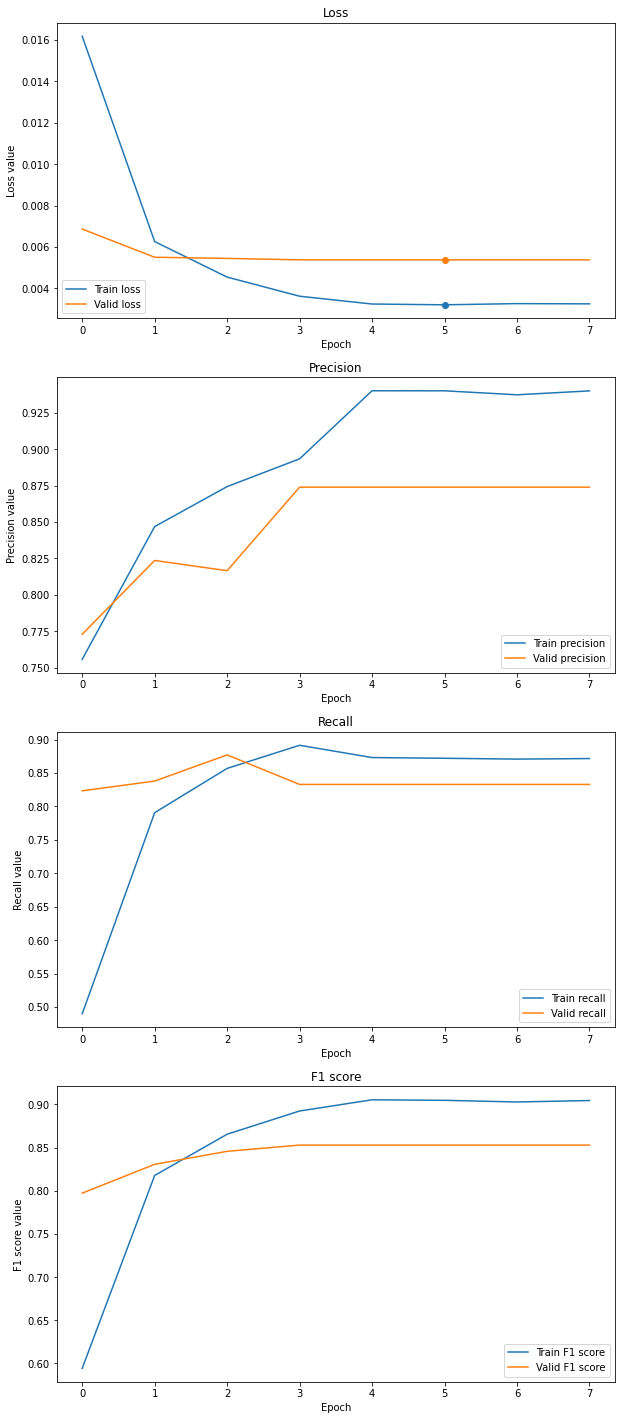

In [ ]:
plot_history()